In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 불러오기
f1=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_현황데이터.csv")
f2=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_실시간가격.csv")#실제 가격이 들어있는 데이터
f3=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_1.csv")
f4=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_2.csv")
f5=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_하루전가격.csv")

In [ ]:
merged_df_f1_f2 = pd.merge(f1, f2, on='ts', how='inner')
y=merged_df_f1_f2["실시간 확정 가격(원/kWh)"]
X=merged_df_f1_f2.drop(columns=["실시간 확정 가격(원/kWh)","실시간 임시 가격(원/kWh)","ts"])

In [ ]:
between_indices = y[(y > -1) & (y < 1)].index

# X와 y에서 해당 인덱스를 제거
X = X.drop(between_indices)
y = y.drop(between_indices)


In [ ]:
train_X, val_X, test_X = X[:4500], X[4500:5000], X[5000:5096]
train_y, val_y, test_y = y[:4500], y[4500:5000], y[5000:5096]

# Normalize 제거 - X와 y 모두 원래 스케일 사용

# 2. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)  # X를 그대로 사용
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)  # y를 그대로 사용

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 64
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

# MSELoss 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. Training function
def train(dataloader, model, optimizer, criterion):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:>8f}")

# 6. Validation function
def validate(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            total_loss += loss.item()
    avg_loss = total_loss / num_batches
    print(f"Validation Error: Avg loss: {avg_loss:>8f}")

# 7. Training loop
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer, criterion)
    validate(val_dataloader, model, criterion)
print("Done!")

# Run test
print("Testing on unseen data:")


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 1374760.750000  [    0/ 4500]
loss: 372598.750000  [  640/ 4500]
loss: 162661.656250  [ 1280/ 4500]
loss: 73828.843750  [ 1920/ 4500]
loss: 32442.779297  [ 2560/ 4500]
loss: 17556.574219  [ 3200/ 4500]
loss: 17554.285156  [ 3840/ 4500]
loss: 18313.351562  [ 1400/ 4500]
Average training loss: 174940.448916
Validation Error: Avg loss: 18513.403320
Epoch 2
-------------------------------
loss: 16683.675781  [    0/ 4500]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 16233.270508  [  640/ 4500]
loss: 16704.589844  [ 1280/ 4500]
loss: 15432.576172  [ 1920/ 4500]
loss: 15628.411133  [ 2560/ 4500]
loss: 16017.958984  [ 3200/ 4500]
loss: 15613.593750  [ 3840/ 4500]
loss: 14699.718750  [ 1400/ 4500]
Average training loss: 16070.515157
Validation Error: Avg loss: 16245.441772
Epoch 3
-------------------------------
loss: 14352.676758  [    0/ 4500]
loss: 15140.243164  [  640/ 4500]
loss: 14473.260742  [ 1280/ 4500]
loss: 14121.606445  [ 1920/ 4500]
loss: 12573.028320  [ 2560/ 4500]
loss: 13173.540039  [ 3200/ 4500]
loss: 11660.625000  [ 3840/ 4500]
loss: 13899.281250  [ 1400/ 4500]
Average training loss: 13712.811358
Validation Error: Avg loss: 13190.429199
Epoch 4
-------------------------------
loss: 12307.938477  [    0/ 4500]
loss: 12955.101562  [  640/ 4500]
loss: 11999.612305  [ 1280/ 4500]
loss: 10791.541992  [ 1920/ 4500]
loss: 12032.330078  [ 2560/ 4500]
loss: 9443.232422  [ 3200/ 4500]
loss: 9503.626953  [ 3840/ 4500]
loss: 7370.662109  [

In [ ]:
import torch

def customloss(predict, y):
    # predict와 y가 batch 단위로 입력된다고 가정하고 수정
    # predict와 y는 각각 (batch_size,) 또는 (batch_size, num_features) 형태의 tensor라고 가정

    # e1과 e2는 배치 내 모든 샘플에 대해 계산되므로 각 배치 크기만큼의 0 텐서를 초기화
    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)  # batch 내 샘플 개수만큼의 accuracy 초기화

    # y > 0인 경우 e1을 계산하고, y <= 0인 경우 e2를 계산합니다.
    # 이를 위해 boolean indexing을 사용하여 조건에 맞는 요소들만 선택합니다.
    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y <= 0  # y <= 0인 부분 마스크

    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs(y[e1_mask] - predict[e1_mask]) / (y[e1_mask] + 1e-7)
    e2[e2_mask] = torch.abs(y[e2_mask] - predict[e2_mask]) / (-y[e2_mask] + 1e-7)



    # 정확도 계산: y > 0일 때 predict도 > 0, y <= 0일 때 predict도 <= 0이면 accuracy = 1
    accuracy[e1_mask] = (predict[e1_mask] > 0).float()  # y > 0일 때 predict > 0이면 1
    accuracy[e2_mask] = (predict[e2_mask] <= 0).float()  # y <= 0일 때 predict <= 0이면 1

    # e_F 계산: e1과 e2의 weighted sum - (accuracy - 0.95)
    e_F = 0.2 * e1 + 0.8 * e2 - (accuracy - 0.95)

    # e_F를 제곱하여 loss 값으로 반환합니다.
    # e_F는 각 샘플에 대한 값이므로 최종 loss는 batch 차원에 대해 평균을 취합니다.
    e_F_square = e_F**2

    e1_non_zero_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_non_zero_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)
    mean_difference = torch.abs((predict - y)).mean()

    print("accuracy는 ",accuracy.mean())
    print(f"e1 (0 제외 평균): {e1_non_zero_mean}")
    print(f"e2 (0 제외 평균): {e2_non_zero_mean}")
    print("e_F의 값은",e_F.mean())
    print("predict와 y의 평균 차이는 ",mean_difference)
    return e_F_square.mean()  # batch-wise 평균 loss 반환

모델 예측 검증 부분

In [ ]:
test_X =X[5000:5450]
test_y =y[5000:5450]
batch_size = 64

test_dataset = CustomDataset(test_X, test_y)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import pandas as pd

def predict_and_compare(dataloader, model):
    model.eval()  # 모델을 평가 모드로 전환
    predictions = []
    actuals = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X).cpu().squeeze()  # 예측 값, 1차원 텐서로 변환
            predictions.extend(pred.tolist())  # 예측 값 리스트에 추가
            actuals.extend(y.tolist())         # 실제 값 리스트에 추가

    # DataFrame 생성
    df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions
    })

    return df

# 테스트 데이터셋을 통해 예측 및 비교
result_df = predict_and_compare(test_dataloader, model)
result_df


,Actual,Predicted
0,106.019997,116.178040
1,95.800003,113.216667
2,95.500000,110.742561
3,92.190002,109.709625
4,95.500000,109.965675
...,...,...
445,101.220001,102.470085
446,101.339996,116.485947
447,109.089996,116.587776
448,108.580002,123.972374


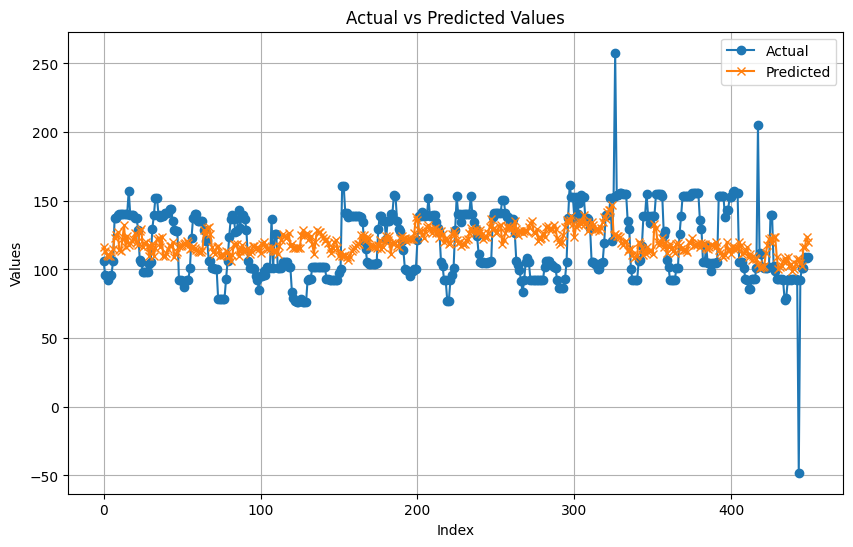

In [ ]:
import matplotlib.pyplot as plt

# Sample data to simulate the user's `result_df` with 'Actual' and 'Predicted' columns
import pandas as pd
import numpy as np

# Creating a sample DataFrame to represent result_df with 'Actual' and 'Predicted' columns


# Plotting the 'Actual' and 'Predicted' values in a line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Actual'], label='Actual', marker='o')
plt.plot(result_df.index, result_df['Predicted'], label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import pandas as pd

# 예측 및 실제 값 비교 후 result_df 생성 (위 코드에서 구현된 함수 사용)
#result_df = predict_and_compare(test_dataloader, model)

# DataFrame을 텐서로 변환
y_tensor = torch.tensor(result_df['Actual'].values, dtype=torch.float32)
predict_tensor = torch.tensor(result_df['Predicted'].values, dtype=torch.float32)

# customloss 함수에 텐서 입력
loss = customloss(predict_tensor, y_tensor)
print(f"Custom Loss: {loss.item()}")


accuracy는  tensor(0.9978)
e1 (0 제외 평균): 0.1889701634645462
e2 (0 제외 평균): 3.2410500049591064
e_F의 값은 tensor(-0.0043)
predict와 y의 평균 차이는  tensor(21.7319)
Custom Loss: 0.028551796451210976
